In [15]:
import astropy.constants as cst
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np


## Cosmology

In [16]:
# Models from Planck+18 (CMB-TT,TE,EE + lensing + BAO + SNe)
LCDM = {"Omega_m": 0.3111, "H0": 67.66, "w0": -1.0, "wa": 0.0}
wCDM = {"Omega_m": 0.3057, "H0": 68.34, "w0": -1.028, "wa": 0.0}
w0waCDM = {"Omega_m": 0.3065, "H0": 68.31, "w0": -0.957, "wa": -0.29}

# Choice of cosmology
cosmo = w0waCDM


## Velocity shift

In [17]:
def vshift(z, Delta_t0, cosmo_params):
    """
    Theoretical velocity shift observed after *Delta_t0* years at a redshfit z
    with a cosmology given by the chosen cosmo_params.
    """
    # Final quantity is expressed in cm/s
    hubble_to_cgs = (u.km / u.s / u.Mpc).to("s-1")
    # E(z): Dimensionless Hubble parameter
    E = np.sqrt(
        cosmo_params["Omega_m"] * (1 + z) ** 3
        + (1 - cosmo_params["Omega_m"])
        * (1 + z) ** (3 * (1 + cosmo_params["w0"] + cosmo_params["wa"]))
        * np.exp(-3 * cosmo_params["wa"] * z / (1 + z))
    )
    # Conversion in velocity shift
    Delta_v = (
        cst.c.cgs.value
        * (cosmo_params["H0"] * hubble_to_cgs)
        * (Delta_t0 * u.year.to("s"))
        * (1 - E / (1 + z))
    )
    return Delta_v


## Mock SKA2

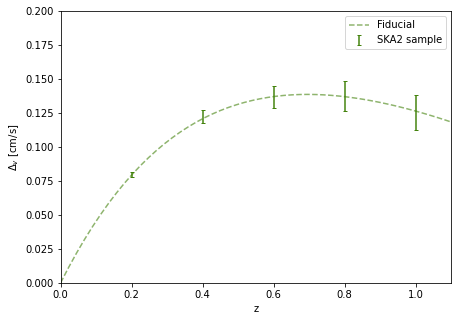

In [18]:
# Half a year between observations
Delta_t0 = 0.5

# Fiducial signal
z = np.linspace(0.2, 1.0, 5)  # 5 bins
Delta_v = vshift(z, Delta_t0, cosmo)

# Errors and noise
err = z * 0.1 * Delta_v
Delta_v += np.random.normal(0, err / 4)

# Plot
z_span = np.linspace(0, 1.1)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(
    z_span,
    vshift(z_span, Delta_t0, cosmo),
    "--",
    c="#43820C",
    alpha=0.6,
    label="Fiducial",
)
ax.errorbar(
    z, Delta_v, yerr=err, linestyle="", capsize=2, color="#43820C", label="SKA2 sample"
)
ax.set(
    xlim=(z_span[0], z_span[-1]), ylim=(0, 0.2), xlabel="z", ylabel=r"$\Delta_v$ [cm/s]"
)
ax.legend()

# Generate the mock file
out = "./SKA2_6months.dat"
with open(out, "w") as file:
    file.write(
        "# Fiducial parameters, Omega_m = {:.4f}, h = {:.2f}, w0_fld = {:.3f}, wa_fld = {:.3f}\r".format(
            cosmo["Omega_m"], cosmo["H0"] / 100, cosmo["w0"], cosmo["wa"]
        )
    )
    for i in range(len(z)):
        file.write("{:.1f} {:.8f} {:.8f}\r".format(z[i], Delta_v[i], err[i]))


## Mock ELT

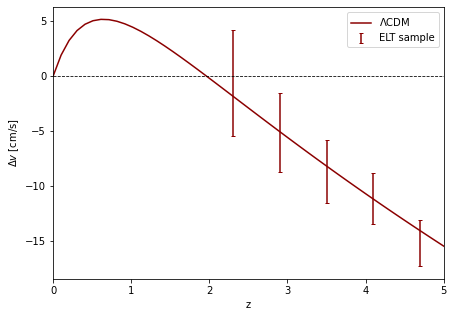

In [24]:
# Settings
Delta_t0 = 20
SNR = 3000
sample_size = 30
n_bins = 5

# Binning
z = np.linspace(2, 5, sample_size)
N_QSOs, limits = np.histogram(z, bins=n_bins)
z_binned = np.zeros(len(N_QSOs))
for i in range(len(z_binned)):
    z_binned[i] = 0.5 * (limits[i] + limits[i + 1])

# Uncertainties
err = np.zeros_like(z_binned)
for i in range(len(err)):
    if z_binned[i] <= 4:
        err[i] = (
            1.35 * 2370 / SNR * np.sqrt(30 / N_QSOs[i]) * (5 / (1 + z_binned[i])) ** 1.7
        )
    else:
        err[i] = (
            1.35 * 2370 / SNR * np.sqrt(30 / N_QSOs[i]) * (5 / (1 + z_binned[i])) ** 0.9
        )

# Mock
Delta_v = vshift(z_binned, Delta_t0, LCDM) + np.random.normal(0, err / 4)

# Plot
z_span = np.linspace(0, 5)
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(z_span, vshift(z_span, Delta_t0, LCDM), c="darkred", label=r"$\Lambda$CDM")
ax.errorbar(
    z_binned,
    Delta_v,
    yerr=err,
    linestyle="",
    capsize=2,
    color="darkred",
    label="ELT sample",
)
ax.set(xlim=(z_span[0], z_span[-1]), xlabel="z", ylabel=r"$\Delta v$ [cm/s]")
ax.axhline(0, ls="--", color="k", lw=0.8)
ax.legend()

# Generate the mock file
out = "./ELT_20years.dat"
with open(out, "w") as file:
    file.write(
        "# Fiducial parameters, Omega_m = {:.4f}, h = {:.2f}, w0_fld = {:.3f}, wa_fld = {:.3f}\r".format(
            cosmo["Omega_m"], cosmo["H0"] / 100, cosmo["w0"], cosmo["wa"]
        )
    )
    for i in range(len(z_binned)):
        file.write("{:.1f} {:.8f} {:.8f}\r".format(z[i], Delta_v[i], err[i]))
